In [1]:
import pandas as pd
import numpy as np
import csv
import pickle
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
Path='/home/mgander/Atlantic/data/Viability/'

In [3]:
M0=pd.read_pickle(f'{Path}/CCLE/M.pkl')
M1=pd.read_pickle(f'{Path}/CTPR/M.pkl')
M2=M=pd.read_pickle(f'{Path}/GDSC/M.pkl')
M3=pd.read_pickle(f'{Path}/DTP/M.pkl')
M4=pd.read_pickle(f'{Path}/NCI60/M.pkl')
M5=pd.read_pickle(f'{Path}/PRISM/M.pkl')

In [4]:
M=pd.concat([M0, M1, M2, M3, M4, M5], ignore_index=True)
#M=pd.concat([M0, M1, M2, M3, M4], ignore_index=True)
M['Source']=M['Source'].astype('str').astype('category')
M['CCL']=M['CCL'].astype('str')
len(M)

51426153

In [5]:
M=M.drop_duplicates(subset=['CCL', 'Drug', 'Dose', 'Duration', 'Viability', 'Source']).copy()
len(M)

50492805

# Cell line renaming

Map everything onto CelloSaurus Names to remove cell line naming ambiguity

In [6]:
def purge_and_capitalize(ccl):
    ccl_str=ccl.replace('-', '')
    ccl_str=ccl_str.replace(' ', '')
    return(ccl_str.upper())

In [7]:
# Let's remove '-' and spaces and capitalize everything

ccls=sorted(set(M['CCL']))

D_ccl={}

for ccl in ccls:
    D_ccl[ccl]=purge_and_capitalize(ccl)
M['CCL_reduced']=[D_ccl[a] for a in M['CCL']]
ccl_red=sorted(set(M['CCL_reduced']))
len(ccl_red)

1415

## Map everything to Cellosaurus

In [8]:
dfc=pd.read_pickle(f'{Path}/CCL_dict/Cellosaurus_CCLs.pkl')
dfc=dfc[dfc['Species']=='NCBI_TaxID=9606; ! Homo sapiens (Human)']
dfc

,Cellosaurus_ID,Acesion,Synonyms,Species
2,#15310LN,CVCL_E548,15310LN; TER461; TER461; TER461; TER479; TER47...,NCBI_TaxID=9606; ! Homo sapiens (Human)
8,#W7079,CVCL_E549,#W7079REM; REMUS; W7079,NCBI_TaxID=9606; ! Homo sapiens (Human)
10,(L)PC6,CVCL_VG99,,NCBI_TaxID=9606; ! Homo sapiens (Human)
18,0.5ALPHA,CVCL_B5B3,0.5ALPHA,NCBI_TaxID=9606; ! Homo sapiens (Human)
19,00136,CVCL_E557,136,NCBI_TaxID=9606; ! Homo sapiens (Human)
...,...,...,...,...
148676,ZZUSAHI001A,CVCL_ZB29,KCNA5V259IIPSC,NCBI_TaxID=9606; ! Homo sapiens (Human)
148677,ZZUSAHI002A,CVCL_ZB30,,NCBI_TaxID=9606; ! Homo sapiens (Human)
148678,ZZUSAHI003A,CVCL_A3ZF,,NCBI_TaxID=9606; ! Homo sapiens (Human)
148679,ZZUSAHI004A,CVCL_C6U7,,NCBI_TaxID=9606; ! Homo sapiens (Human)


In [9]:
# Use the synonyms to map to the Cellosaurus ID
cellosaurus_ids=list(dfc['Cellosaurus_ID'])
syns=list(dfc['Synonyms'])

syn_l=[]
for s in syns:
    if '; ' in s:
        syn_l.append(s.split('; '))
    else:
        syn_l.append(s)
D_cello={cellosaurus_ids[i]:cellosaurus_ids[i] for i in range(len(cellosaurus_ids))}

for i in range(len(syn_l)):
    for s in syn_l[i]:
        D_cello[s]=cellosaurus_ids[i]

In [10]:
ccl_red=sorted(set(M['CCL_reduced']))
for ccl in ccl_red:
    if ccl in cellosaurus_ids:
        D_cello[ccl]=ccl

In [11]:
D_cello['CJM']='CJM'
D_cello['CJM[HUMANMELANOMA]']='CJM'
D_cello['HARA']='HARA'
D_cello['HARA[HUMANSQUAMOUSCELLLUNGCARCINOMA]']='HARA'
D_cello['HH']='HH'
D_cello['HH[HUMANLYMPHOMA]']='HH'

D_cello['K2']='K2'
D_cello['K2[HUMANTHYROIDCARCINOMA]']='K2'

# My guess is they switched up the letters and KRIJ is supposed to be KRJ-I
D_cello['KRIJ']='KRJI'

D_cello['KS1']='KS1'
D_cello['KS1[HUMANGLIOBLASTOMA]']='KS1'

D_cello['ML1']='ML1'
D_cello['ML1[HUMANLEUKEMIA]']='ML1'

D_cello['PC3_[JPC3]']='PC3JPC3'
D_cello['PC3[HUMANLUNGCARCINOMA]']='PC3JPC3'

D_cello['SAT']='SAT'
D_cello['SAT[HUMANHNSCC]']='SAT'

D_cello['TK']='TK'
D_cello['TK[HUMANBCELLLYMPHOMA]']='TK'

D_cello['TTTHYROID']='TT'

In [12]:
keys=list(D_cello.keys())

In [13]:
ccls=sorted(set(M['CCL']))
dfm=M[['CCL', 'CCL_reduced']].copy()
dfm=dfm.drop_duplicates()

In [14]:
# missing, i.e. these cell lines could not be mapped onto a cellosaurus-ID
for i in range(len(dfm)):
    ccl_red=dfm.iloc[i]['CCL_reduced']
    ccl=dfm.iloc[i]['CCL']
    
    if ccl_red[-7:]=='/H.FINE':
        if ccl_red[:-7] in keys:
            D_cello[ccl_red]=D_cello[ccl_red[:-7]]
            keys=list(D_cello.keys())
            
    if ccl_red[-5:]=='/ATCC':
        if ccl_red[:-5] in keys:
            D_cello[ccl_red]=D_cello[ccl_red[:-5]]
            keys=list(D_cello.keys())
    
    if not ccl_red in keys:
        print(f'{ccl}:{ccl_red}')

L33:L33
P388:P388
P388/ADR:P388/ADR
T47D ERE4:T47DERE4
T47D FOS1:T47DFOS1
T47D NFkB15:T47DNFKB15
COLO 746:COLO746
CXF 264L:CXF264L
H1299p53RE29:H1299P53RE29
HCT-116/CMV-1:HCT116/CMV1
HCT-116/CMV-2:HCT116/CMV2
HCT-116/E6-1:HCT116/E61
HCT-116/P:HCT116/P
HCT-116/P21/A:HCT116/P21/A
HCT-116/P21/B:HCT116/P21/B
HCT-116/P21/C:HCT116/P21/C
HCT-116/PV:HCT116/PV
HT29p53RE22:HT29P53RE22
MLI-059:MLI059
RKO Waf1:RKOWAF1
RKOp53RE1:RKOP53RE1
A-C/EBP 3:AC/EBP3
A-CREB 1:ACREB1
A-CREB 2:ACREB2
A-FOS 2:AFOS2
A-FOS 3:AFOS3
A-JUN 1:AJUN1
A-JUN 3:AJUN3
UABMEL3:UABMEL3
LXFS 650L:LXFS650L
MLI-045:MLI045
MLI-076:MLI076
UABLG22:UABLG22
TSU-PRI:TSUPRI
UOK-57:UOK57
HCT-116/E6-2:HCT116/E62
CHO:CHO
CHO/159-1:CHO/1591
NYH/ICRF-187-1:NYH/ICRF1871
MLI-019:MLI019
VDSO/CMV-8:VDSO/CMV8
VDSO/CMV-9:VDSO/CMV9
VDSO/E6-18:VDSO/E618
VDSO/E6-19:VDSO/E619
VDSO/P:VDSO/P
A673STAG2KO16:A673STAG2KO16
A673STAG2KO45:A673STAG2KO45
A673STAG2NT14:A673STAG2NT14
A673STAG2NT23:A673STAG2NT23
KD:KD


In [15]:
D_cello['T47DERE4']='T47D'
D_cello['T47DFOS1']='T47D'
D_cello['T47DNFKB15']='T47D'
D_cello['HCT116/CMV1']='p53HCT116'
D_cello['HCT116/CMV2']='p53HCT116'
D_cello['HCT116/E61']='p53HCT116'
D_cello['HCT116/P21/A']='p53HCT116'
D_cello['HCT116/P21/B']='p53HCT116'
D_cello['HCT116/P21/C']='p53HCT116'
D_cello['HCT116/P21/C']='p53HCT116'
D_cello['HCT116/P']='p53HCT116'
D_cello['RKOWAF1']='RKO'
D_cello['RKOP53RE1']='P53R'
D_cello['TSUPRI']='TSUPR1'
D_cello['HCT116/E62']='HCT116'
D_cello['NYH/ICRF1871']='GLC2'
D_cello['MLI019']='MLI003A'
D_cello['KD']='KD[HUMANABDOMENRHABDOIDTUMOR]'

In [16]:
D_cello['COLO746']='nan'
D_cello['CXF264L']='nan'
D_cello['H1299P53RE29']='nan'
D_cello['HT29P53RE22']='nan'
D_cello['MLI059']='nan'
D_cello['AC/EBP3']='nan'
D_cello['ACREB1']='nan'
D_cello['ACREB2']='nan'
D_cello['AFOS2']='nan'
D_cello['AFOS3']='nan'
D_cello['AJUN1']='nan'
D_cello['AJUN3']='nan'
D_cello['UABMEL3']='nan'
D_cello['LXFS650L']='nan'
D_cello['MLI045']='nan'
D_cello['MLI076']='nan'
D_cello['UABLG22']='nan'
D_cello['UOK57']='nan'
D_cello['CHO/1591']='nan'
D_cello['VDSO/CMV8']='nan'
D_cello['VDSO/CMV9']='nan'
D_cello['VDSO/E618']='nan'
D_cello['VDSO/E619']='nan'
D_cello['VDSO/P']='nan'
D_cello['A673STAG2KO16']='nan'
D_cello['A673STAG2KO45']='nan'
D_cello['A673STAG2NT14']='nan'
D_cello['A673STAG2NT23']='nan'
D_cello['AC/EBP3']='nan'
D_cello['ACREB1']='nan'
D_cello['ACREB2']='nan'
D_cello['MIN6M14']='nan'
D_cello['CHO']='nan'
D_cello['L33']='L3.3'
D_cello['HCT116/PV']='nan'
D_cello['P388']='nan'
D_cello['P388/ADR']='nan'
D_cello['']='nan'
D_cello['']='nan'

In [17]:
keys=list(D_cello.keys())
# Still missing
for ccl_red in list(set(M['CCL_reduced'])):
    if not ccl_red in keys:
        print(f'{ccl_red}')

In [20]:
M['Cello']=M['CCL_reduced'].map(D_cello)

In [21]:
len(M)

50492805

In [22]:
M=M[M['Cello']!='nan'].copy()

In [23]:
len(M)

50428490

# Map Drugs to PubChemID

In [24]:
dfn=pd.read_pickle(f'{Path}/Drug_dict/Mapped_compound_names.pkl')
drugs=list(dfn['Drug'])
cids=list(dfn['Reduced_CID'])

In [25]:
D_drug_name_to_Pubchem={drugs[i]:cids[i] for i in range(len(drugs))}
#D_drug_name_to_Pubchem['nan']=D_drug_name_to_Pubchem['nan']

In [26]:
M['PubChem_CID']=M['Drug'].map(D_drug_name_to_Pubchem).astype('str')

In [27]:
Ms=M[M['PubChem_CID']=='nan'].copy()

In [28]:
set(Ms['Drug'].astype('str'))

{'BTS', 'CPP'}

In [29]:
M=M[M['PubChem_CID']!='nan'].copy()

In [30]:
len(set(M['PubChem_CID']))

26904

<Axes: ylabel='Count'>

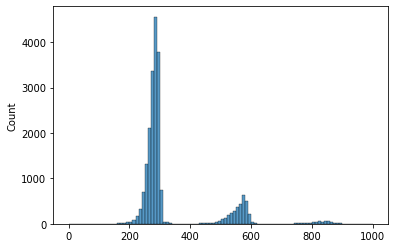

In [31]:
vc=M['PubChem_CID'].value_counts()
sns.histplot(x=vc.values, bins=np.linspace(0,10**3, 101))

In [32]:
# And find a drug representative name
D_inv={}
for k in D_drug_name_to_Pubchem.keys():
    D_inv[D_drug_name_to_Pubchem[k]]=k
M['Dr_repr_name']=[D_inv[a] for a in M['PubChem_CID']]

In [33]:
M['Dr_repr_name'].value_counts()

Dr_repr_name
MG-132                                                                                      466953
staurosporine                                                                               416056
bortezomib                                                                                  157797
afatinib                                                                                    130219
PD0325901                                                                                   110949
                                                                                             ...  
N-(2-Ethoxyphenyl)-2-(1-oxido-3-oxo-3,4-dihydro-2H-1,4-benzothiazin-2-yl)-2-oxoacetamide       150
N-(2,4-Dichlorophenyl)-N'-(4-oxo-2-thioxo-1,4-dihydroquinazolin-3(2H)-yl)ethanediamide         150
3,5-Diphenyloxazol-2-one                                                                       149
Schultesine                                                                                    1

In [34]:
M.to_pickle(f'{Path}/M_all_all.pkl')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
Path='/home/mgander/Atlantic/data/Viability/'

In [ ]:
M=pd.read_pickle(f'{Path}/M_all_all.pkl')

In [35]:
M.head()

,CCL,Drug,Dose,Duration,Viability,Source,CCL_reduced,Cello,PubChem_CID,Dr_repr_name
0,CAS1,CIL55,0.00030,72.0,0.948448,CTD2,CAS1,CAS1,6623618,CIL55
1,CAS1,CIL55,0.00030,72.0,0.912565,CTD2,CAS1,CAS1,6623618,CIL55
2,CAS1,CIL55,0.00061,72.0,0.880625,CTD2,CAS1,CAS1,6623618,CIL55
3,CAS1,CIL55,0.00061,72.0,0.789330,CTD2,CAS1,CAS1,6623618,CIL55
4,CAS1,CIL55,0.00120,72.0,0.973525,CTD2,CAS1,CAS1,6623618,CIL55


## Add doubling times

For some cell line I couldn't find the doubling time, so I put in 40h. Doubling times are highly different for different labs/growth conditions so use this with an enormous amount of caution

In [36]:
def transform_to_0_1(value, doubling_time, time):
    alpha=time/doubling_time
    if value>0:
        return(value/100*(1-2**(-alpha))+2**(-alpha))
    if value<=0:
        return(2**(-alpha)*(value/100+1))

In [37]:
df=pd.read_csv(f'{Path}/NCI60_CRC65_CCL.csv')
doubling_times=[a.replace(',', '.') for a in df['Doubling_time']]
doubling_times=[float(a) if a!='mouse' else np.NaN for a in doubling_times]
df['Doubling_time_float']=doubling_times
D_doubling_time={df.iloc[i]['CCL']:df.iloc[i]['Doubling_time_float'] for i in range(len(doubling_times))}
D_keys=list(D_doubling_time.keys())

cellos=list(set(M['Cello']))
for c in cellos:
    if not c in D_keys:
        # Maybe it makes sense to put 40h here as a generic doubling time value
        D_doubling_time[c]=np.NaN

In [38]:
set(M['Source'])

{'CTD2', 'CTPR', 'DTP', 'GDSC1', 'GDSC2', 'MR_NCI60', 'PRISM1', 'PRISM2'}

In [39]:
sources=list(M['Source'])
ccls=list(M['Cello'])
times=list(M['Duration'])
viabs=list(M['Viability'])
wh=np.where(M['Source']=='DTP')[0]
for i in wh:
    viabs[i]=transform_to_0_1(viabs[i], D_doubling_time[ccls[i]], times[i])
    if i%10**5==0:
        print(i)

20100000
20200000
20300000
20400000
20500000
20600000
20700000
20800000
20900000
21000000
21100000
21200000
21300000
21400000
21500000
21600000
21700000
21800000
21900000
22000000
22100000
22200000
22300000
22400000
22500000
22600000
22700000
22800000
22900000
23000000
23100000
23200000
23300000
23400000
23500000
23600000
23700000
23800000
23900000
24000000
24100000
24200000
24300000
24400000
24500000
24600000
24700000
24800000
24900000
25000000
25100000
25200000
25300000
25400000
25500000
25600000
25700000
25800000
25900000
26000000
26100000
26200000
26300000
26400000
26500000
26600000
26700000
26800000
26900000
27000000
27100000
27200000
27300000
27400000
27500000
27600000
27700000
27800000
27900000
28000000
28100000
28200000
28300000
28400000
28500000
28600000
28700000
28800000
28900000
29000000
29100000
29200000
29300000


In [40]:
M[M['Source']=='DTP']

,CCL,Drug,Dose,Duration,Viability,Source,CCL_reduced,Cello,PubChem_CID,Dr_repr_name
20171677,SF-268,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl...",0.01,48.0,92.7,DTP,SF268,SF268,362451,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl..."
20171678,SF-268,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl...",0.10,48.0,96.1,DTP,SF268,SF268,362451,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl..."
20171679,SF-268,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl...",1.00,48.0,96.3,DTP,SF268,SF268,362451,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl..."
20171680,SF-268,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl...",10.00,48.0,92.6,DTP,SF268,SF268,362451,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl..."
20171681,SF-268,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl...",100.00,48.0,13.2,DTP,SF268,SF268,362451,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl..."
...,...,...,...,...,...,...,...,...,...,...
30277153,DMS 273,9-Acetamido-10-hydroxy-20-(S)-camptothecin,1.00,48.0,20.5,DTP,DMS273,DMS273,44315616,9-Acetamido-10-hydroxy-20-(S)-camptothecin
30277154,DMS 273,9-Acetamido-10-hydroxy-20-(S)-camptothecin,10.00,48.0,8.5,DTP,DMS273,DMS273,44315616,9-Acetamido-10-hydroxy-20-(S)-camptothecin
30277155,DMS 273,9-Acetamido-10-hydroxy-20-(S)-camptothecin,10.00,48.0,-32.0,DTP,DMS273,DMS273,44315616,9-Acetamido-10-hydroxy-20-(S)-camptothecin
30277156,DMS 273,9-Acetamido-10-hydroxy-20-(S)-camptothecin,100.00,48.0,-9.7,DTP,DMS273,DMS273,44315616,9-Acetamido-10-hydroxy-20-(S)-camptothecin


In [41]:
M['Viability']=viabs
M[M['Source']=='DTP']

,CCL,Drug,Dose,Duration,Viability,Source,CCL_reduced,Cello,PubChem_CID,Dr_repr_name
20171677,SF-268,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl...",0.01,48.0,0.953717,DTP,SF268,SF268,362451,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl..."
20171678,SF-268,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl...",0.10,48.0,0.975273,DTP,SF268,SF268,362451,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl..."
20171679,SF-268,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl...",1.00,48.0,0.976541,DTP,SF268,SF268,362451,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl..."
20171680,SF-268,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl...",10.00,48.0,0.953083,DTP,SF268,SF268,362451,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl..."
20171681,SF-268,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl...",100.00,48.0,0.449673,DTP,SF268,SF268,362451,"1,4-Naphthalenedione, 2,2'-(1H-indole-2,3-diyl..."
...,...,...,...,...,...,...,...,...,...,...
30277153,DMS 273,9-Acetamido-10-hydroxy-20-(S)-camptothecin,1.00,48.0,0.233538,DTP,DMS273,DMS273,44315616,9-Acetamido-10-hydroxy-20-(S)-camptothecin
30277154,DMS 273,9-Acetamido-10-hydroxy-20-(S)-camptothecin,10.00,48.0,0.117846,DTP,DMS273,DMS273,44315616,9-Acetamido-10-hydroxy-20-(S)-camptothecin
30277155,DMS 273,9-Acetamido-10-hydroxy-20-(S)-camptothecin,10.00,48.0,0.024410,DTP,DMS273,DMS273,44315616,9-Acetamido-10-hydroxy-20-(S)-camptothecin
30277156,DMS 273,9-Acetamido-10-hydroxy-20-(S)-camptothecin,100.00,48.0,0.032415,DTP,DMS273,DMS273,44315616,9-Acetamido-10-hydroxy-20-(S)-camptothecin


<AxesSubplot:ylabel='Count'>

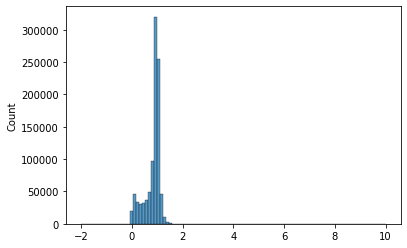

In [46]:
np.random.shuffle(viabs)
a=viabs[:10**6]
sns.histplot(a, bins=np.linspace(-2,10,101))

In [42]:
M.head()

,CCL,Drug,Dose,Duration,Viability,Source,CCL_reduced,Cello,PubChem_CID,Dr_repr_name
0,CAS1,CIL55,0.00030,72.0,0.948448,CTD2,CAS1,CAS1,6623618,CIL55
1,CAS1,CIL55,0.00030,72.0,0.912565,CTD2,CAS1,CAS1,6623618,CIL55
2,CAS1,CIL55,0.00061,72.0,0.880625,CTD2,CAS1,CAS1,6623618,CIL55
3,CAS1,CIL55,0.00061,72.0,0.789330,CTD2,CAS1,CAS1,6623618,CIL55
4,CAS1,CIL55,0.00120,72.0,0.973525,CTD2,CAS1,CAS1,6623618,CIL55


In [43]:
M.to_pickle(f'{Path}/M_all_all.pkl')